# Документация 

In [1]:
import pandas as pd
import datetime
import numpy as np
from sklearn import preprocessing
from scipy.sparse import csr_matrix

## Описание входныхх данных

Для обучения используется только таблица events:

In [2]:
events = pd.read_csv('data/events.csv')
print(events.shape)
display(events)

(2756101, 5)


,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN
3,1433221955914,483717,view,253185,NaN
4,1433221337106,951259,view,367447,NaN
...,...,...,...,...,...
2756096,1438398785939,591435,view,261427,NaN
2756097,1438399813142,762376,view,115946,NaN
2756098,1438397820527,1251746,view,78144,NaN
2756099,1438398530703,1184451,view,283392,NaN


## Трансформации исходного датасета: 

Сортировка и перевод в формат datatime:

In [3]:
events = events.assign(date=pd.Series(datetime.datetime.fromtimestamp(i/1000).date() for i in events.timestamp))
events = events.sort_values('date').reset_index(drop=True)
events = events[['visitorid','itemid','event', 'date']]
events.head(5)

,visitorid,itemid,event,date
0,567743,42875,view,2015-05-03
1,190672,259357,view,2015-05-03
2,1127598,69533,view,2015-05-03
3,180270,379359,view,2015-05-03
4,425526,440984,view,2015-05-03


Фильтруем данные по времени событий:

In [4]:
start_date = '2015-5-3'
end_date = '2015-5-18'
fd = lambda x: datetime.datetime.strptime(x, '%Y-%m-%d').date()
events = events[(events.date >= fd(start_date)) & (events.date <= fd(end_date))]

Сплитем датасет на обучение и тест для валидации:

In [5]:
split_point = int(np.round(events.shape[0]*0.8))
events_train = events.iloc[0:split_point]
events_test = events.iloc[split_point::]
events_test = events_test[(events_test['visitorid'].isin(events_train['visitorid']))
                          & (events_test['itemid'].isin(events_train['itemid']))]

Кодируем признаки, чтобы использовать их в качестве оценок:

In [6]:
id_cols=['visitorid','itemid']
trans_cat_train=dict()
trans_cat_test=dict()

for k in id_cols:
    cate_enc=preprocessing.LabelEncoder()
    trans_cat_train[k]=cate_enc.fit_transform(events_train[k].values)
    trans_cat_test[k]=cate_enc.transform(events_test[k].values)
    
ratings = dict()

cate_enc=preprocessing.LabelEncoder()
ratings['train'] = cate_enc.fit_transform(events_train.event)
ratings['test'] = cate_enc.transform(events_test.event)    

Создаём item-users sparse-матрицу:

In [7]:
n_users=len(np.unique(trans_cat_train['visitorid']))
n_items=len(np.unique(trans_cat_train['itemid']))

rate_matrix = dict()

#используем разреженные матрицы
rate_matrix['train'] = csr_matrix((ratings['train'],
                                   (trans_cat_train['visitorid'],
                                    trans_cat_train['itemid'])),
                                  shape=(n_users,n_items)
                                  )

rate_matrix['test'] = csr_matrix((ratings['test'],
                                  (trans_cat_test['visitorid'],
                                   trans_cat_test['itemid'])),
                                 shape=(n_users,n_items)
                                 )

## Параметры модели и метрики качества

В качестве модели использовалась ALS:

In [12]:
# модель
from lightfm import LightFM, cross_validation
# для оценки метрик

from lightfm.evaluation import precision_at_k, auc_score

In [9]:
model3 = LightFM(no_components=150, learning_rate=0.05, loss='warp', random_state=42)
model3.fit(rate_matrix['train'], epochs=50, num_threads=4, verbose=True)

Epoch: 100%|██████████| 50/50 [00:08<00:00,  5.92it/s]


Получение рекомендаций:

In [10]:
user_id = 22 # id пользователя
unique_items = np.unique(trans_cat_train['itemid']) # список айтемов

item_ids = np.arange(0, rate_matrix['train'].shape[1])

list_pred = model3.predict(user_id, item_ids)
recomendations_ids = np.argsort(-list_pred)[:10]
recomendations = unique_items[recomendations_ids]
print('Рекомендация для пользователя {}: {}'.format(user_id, recomendations))

Рекомендация для пользователя 22: [52150 49462 14805 15632 47624 53444 17718 48996  7326 40429]


Метрики:

In [16]:
map_at3 = precision_at_k(model3, rate_matrix['test'], k=3).mean()
print('Mean Average Precision at 3: {:.5f}'.format(map_at3))

Mean Average Precision at 3: 0.18744


## Описание docker-образа и сервиса

Код для развертывания локального сервера с моделью:

In [ ]:
#from flask import Flask, request, jsonify
#import pickle
#import numpy as np
#from lightfm import lightfm

#with open(r'model_recom.pkl', 'rb') as pkl_file1: 
#    model = pickle.load(pkl_file1)

#with open(r'unique_items.pkl', 'rb') as pkl_file2: 
#    unique_items = pickle.load(pkl_file2)
    
#with open(r'rate_matrix.pkl', 'rb') as pkl_file3: 
#    rate_matrix = pickle.load(pkl_file3)    
    
#app = Flask(__name__)

#@app.route('/recommendation')
#def hello_func():
#    user = int(request.args.get('user_id'))
#    item_ids = np.arange(0, rate_matrix['train'].shape[1])
#    user_id = user
#    list_pred = model.predict(user_id, item_ids)
#    recomendations_ids = np.argsort(-list_pred)[:3]
#    recomendations = unique_items[recomendations_ids]
#    return f'recommendation for user {user}:{recomendations[:3]}!'


#if __name__ == '__main__':
#    app.run(host='0.0.0.0', port=5000)    

Docker-образ собирается из приложенного Dockerfile(docker build -t project_pred .). В файле requirements указаны необходимые библиотеки. В папке app лежат файл сервера, сохранённая модель и необходимые матрицы в формате pkl.
Организация файлов в директории:
 
  
Final Project

  ├─app

     ├─model_recom.pkl

     ├─rate_matrix.pkl

     ├─unique_items.pkl

     └─server.py

  └─Dockerfile
  
  └─requirements.txt
  
Контейнер запускается из командной строки: docker run -it --rm --name=project_pred -p=5000:5000 project_pred
Далее по адресу http://127.0.0.1:5000/recommendation?user_id=22 можно получить рекомендации трёх товаров для для указанного user_id(указывается как /recommendation?user_id=номер_юзера)

Файл server.py можно запустить отдельно от docker-образа и сразу получить рекомендации на сервере.

Запуск образа:

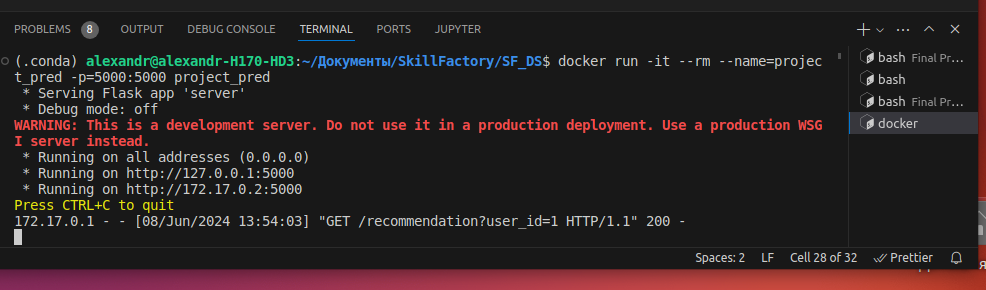

Пример получения рекомендаций:

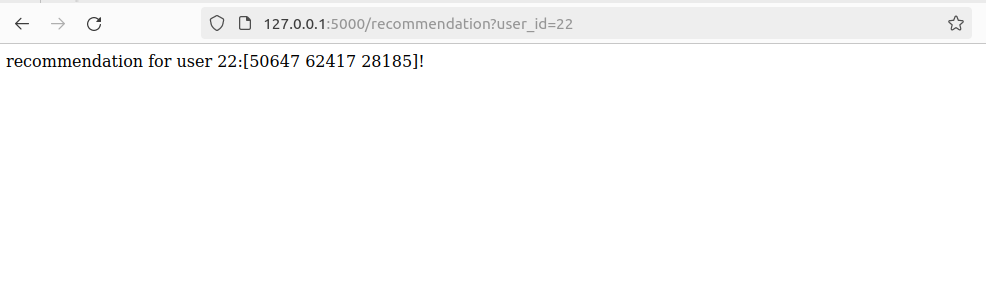